In [81]:
import librosa
import librosa.display
import librosa.core
import numpy as np
from numpy.lib import stride_tricks
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import scipy.signal


%matplotlib inline

def show_spec(spec, sr, hop_length, title=None, name='?', unit='db', ax=None):
    axes = librosa.display.specshow(spec, sr=sr, hop_length=hop_length, y_axis='log', x_axis='s', ax=ax)
    
    title = title if title else 'Power spectrogram of %s' % name
    
    if ax is None:
        plt.title(title)
        plt.colorbar(format='%+2.0f ' + unit, ax=ax)
        plt.tight_layout()
        plt.show()
    else:
        ax.set_title(title)
    return axes

# stft implementation from zhr1201
def stft(sig, frameSize, overlapFac=0.75, window=np.hanning):
    """ short time fourier transform of audio signal """
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    samples = np.array(sig, dtype='float64')
    # cols for windowing
    #cols = int(np.ceil((len(samples) - frameSize) / float(hopSize)) + 1)
    cols = int(np.floor((len(samples) - frameSize) / float(hopSize)) + 1)
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    frames = stride_tricks.as_strided(
        samples,
        shape=(cols, frameSize),
        strides=(samples.strides[0] * hopSize, samples.strides[0])).copy()
    frames *= win
    return np.fft.rfft(frames)

In [82]:
audio_file = "../../workspace/data/WSJ0/train/014/014A0101.WAV.resampled.wav"

SAMPLING_RATE = 8000
test_pcm, _ = librosa.core.load(audio_file, sr=SAMPLING_RATE)

In [83]:
ipd.Markdown("## Comparision of librosa stft vs. own")

# https://musicinformationretrieval.com/stft.html
FRAME_SIZE = 256
HOP_LENGTH = int(FRAME_SIZE / 4)

own_spec = stft(test_pcm, FRAME_SIZE)
print(own_spec[:, :129][0:10,:].shape)
own_spec = np.swapaxes(own_spec, 0, 1)

print("own")
display(ipd.Audio(librosa.istft(own_spec), rate=SAMPLING_RATE))

librosa_spec = librosa.core.stft(test_pcm, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, window=np.hanning(256), center=False)

scipy_spec = scipy.signal.stft(test_pcm, fs=SAMPLING_RATE, window=np.hanning(256), noverlap=0.75 * 256, return_onesided=True, boundary=None, padded=False)

print("librosa")
display(ipd.Audio(librosa.istft(librosa_spec, window=np.hanning(256), hop_length=64, win_length=256,center=False), rate=SAMPLING_RATE))

diff_spec = own_spec - librosa_spec
print("Summed difference: %s" % np.sum(np.abs(diff_spec)))

print("Summed difference: %s" % np.min(np.abs(own_spec) /  np.abs(scipy_spec[2] * 129)))

(10, 129)
own


librosa


Summed difference: 2.0130061996468664e-05
Summed difference: 0.9882240505559211


In [84]:
librosa_spec = librosa.core.stft(test_pcm, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, window=np.hanning(256), center=True, pad_mode='constant')
scipy_spec = scipy.signal.stft(test_pcm, fs=SAMPLING_RATE, window=np.hanning(256), noverlap=0.75 * 256, return_onesided=True, boundary='zeros', padded=False)

print("Summed difference: %s" % np.min(np.abs(librosa_spec) /  np.abs(scipy_spec[2] * 129)))

Summed difference: 0.9882241


Text(0.5, 1.0, 'Monophonic Waveform')

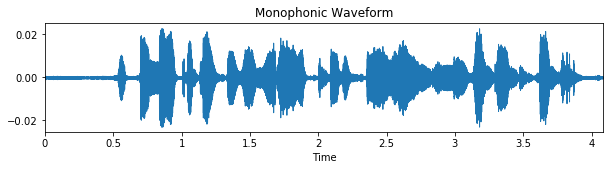

In [85]:
plt.figure(figsize=(10,2))
librosa.display.waveplot(test_pcm, sr=SAMPLING_RATE)
plt.title('Monophonic Waveform')

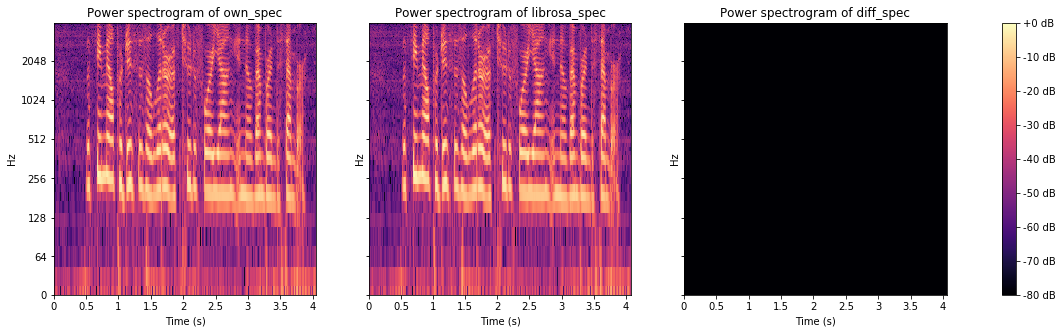

In [86]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,5))
ax1, ax2, ax3 = axes

show_spec(librosa.amplitude_to_db(np.abs(own_spec), ref=np.max), SAMPLING_RATE, HOP_LENGTH, name="own_spec", ax=ax1)
show_spec(librosa.amplitude_to_db(np.abs(librosa_spec), ref=np.max), SAMPLING_RATE, HOP_LENGTH, name="librosa_spec", ax=ax2)
show_spec(librosa.amplitude_to_db(np.abs(diff_spec), ref=np.max), SAMPLING_RATE, HOP_LENGTH, name="diff_spec", ax=ax3)

plt.colorbar(ax1.collections[0], format='%+2.0f dB', ax=axes)

Max frequency is 22000


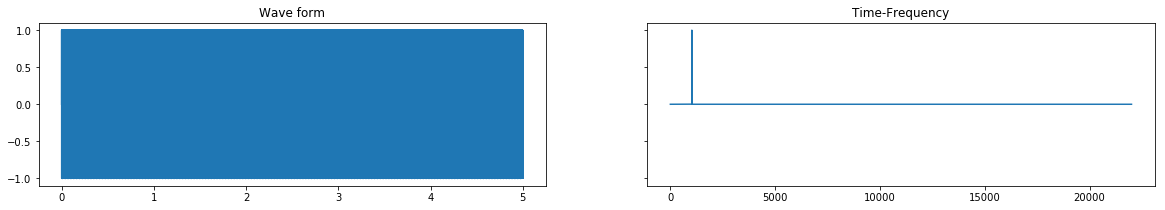

In [87]:
SIN_SAMPLING_RATE = 44000

FRAME_SIZE = 256
NEFF = int((FRAME_SIZE / 2) + 1)

duration = 5
frequency = 1024
amplitude = 1

# Number of samplepoints
N = duration * SIN_SAMPLING_RATE
# sample spacing
T = 1.0 / SIN_SAMPLING_RATE

x = np.linspace(0.0, N*T, N)
y = amplitude * np.sin(frequency * 2.0*np.pi*x)

yf = np.fft.fft(y)
xf = np.linspace(0.0, SIN_SAMPLING_RATE / 2, int(N/2))
yf = 2.0/N * np.abs(yf[:int(N/2)])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,3))

ax1.set_title('Wave form')
ax1.plot(x, y)
ax2.set_title('Time-Frequency')
ax2.plot(xf, yf)

max_frequency = SIN_SAMPLING_RATE / 2
print("Max frequency is %d" % max_frequency)

In [88]:
lookup_frequency = frequency
magnitude = yf[int(lookup_frequency / max_frequency * (N / 2))]
print("Magnitude at %d Hz is %f" % (lookup_frequency, magnitude))

Magnitude at 1024 Hz is 0.999107


own magnitude: 0.998815


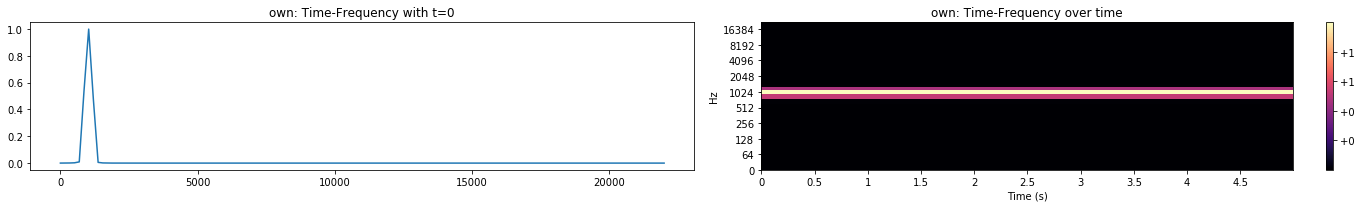

librosa magnitude: 0.998815


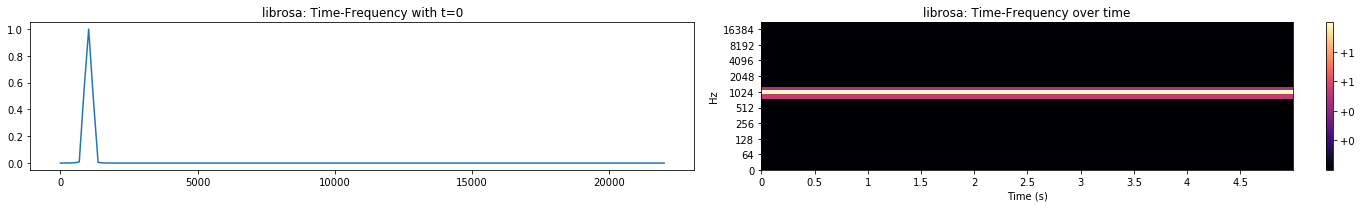

In [89]:
# https://www.cbcity.de/die-fft-mit-python-einfach-erklaert

lookup_frequency = frequency
# Index of bin with specific frequency
bin_index = int(lookup_frequency / (max_frequency) * (FRAME_SIZE / 2) + 1)


window_size = FRAME_SIZE
window = np.hanning(window_size)
hop_length = FRAME_SIZE / 4

# STFT
rosa_st_spec = np.abs(librosa.stft(y, n_fft=FRAME_SIZE, hop_length=int(FRAME_SIZE/4), center=False, window=window))
st_spec = np.abs(stft(y, FRAME_SIZE)) # fixme: Use custom window
st_spec = np.swapaxes(st_spec, 0, 1)

# Normalize according to https://dsp.stackexchange.com/questions/49184/stft-amplitude-normalization-librosa-library
st_spec = 2 * st_spec / np.sum(window)

N = FRAME_SIZE // 2 + 1 # Effictive FFT points
xf = np.linspace(0.0, SIN_SAMPLING_RATE / 2, N)

print("own magnitude: %f" % st_spec[bin_index][0])

fig, axes = plt.subplots(1, 2, sharey=False, figsize=(20,3))
ax1, ax2 = axes
ax1.set_title('own: Time-Frequency with t=0')
ax1.plot(xf, st_spec[:,0])
show_spec(st_spec, SIN_SAMPLING_RATE, HOP_LENGTH, unit='', title="own: Time-Frequency over time")
plt.show()


# Normalize
rosa_st_spec = 2 * rosa_st_spec / np.sum(window)

print("librosa magnitude: %f" % rosa_st_spec[bin_index][0])

fig, axes = plt.subplots(1, 2, sharey=False, figsize=(20,3))
ax1, ax2 = axes
ax1.set_title('librosa: Time-Frequency with t=0')
ax1.plot(xf, rosa_st_spec[:,0])
show_spec(rosa_st_spec, SIN_SAMPLING_RATE, HOP_LENGTH, unit='', title="librosa: Time-Frequency over time")

In [90]:
display(ipd.Markdown("""
## Why are we using the log10 of the spectrum?
"Because audio has a huge dynamic range, it's much better to compute the log of the energy rather than to feed the energy directly" [source](https://people.xiph.org/~jm/demo/rnnoise/)

In the following tests we will evaluate a good way to normalize using log10
"""))

window = np.hanning(FRAME_SIZE)
window_hop_length = FRAME_SIZE / 4
st_spec = np.abs(stft(test_pcm, FRAME_SIZE,)) # fixme: Use custom window
st_spec = np.swapaxes(st_spec, 0, 1)


## Why are we using the log10 of the spectrum?
"Because audio has a huge dynamic range, it's much better to compute the log of the energy rather than to feed the energy directly" [source](https://people.xiph.org/~jm/demo/rnnoise/)

In the following tests we will evaluate a good way to normalize using log10



#### Normalize so amplitude of 1 * sin(t) shows as 1


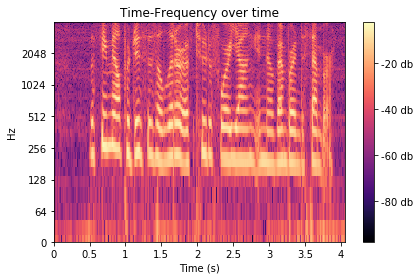

In [91]:
display(ipd.Markdown("""
#### Normalize so amplitude of 1 * sin(t) shows as 1
"""))
ref=np.max(st_spec)
amin=1e-5**2

# Normalize according to https://dsp.stackexchange.com/questions/49184/stft-amplitude-normalization-librosa-library
# What are negative frequencies? https://dsp.stackexchange.com/questions/431/what-is-the-physical-significance-of-negative-frequencies
# What does a fft look like? https://wiki.analytica.com/index.php?title=FFT#Nyquist_frequency.2C_aliasing.2C_mirroring

st_spec_1 = 2 * st_spec / np.sum(window)
st_spec_1 = np.square(st_spec)
st_spec_1 = 10.0 * np.log10(np.maximum(amin, st_spec_1) / ref)

show_spec(st_spec_1, SAMPLING_RATE, HOP_LENGTH, unit='db', title="Time-Frequency over time")


#### Normalize like zhr1201


1.8060532451737288
81.80605324517374


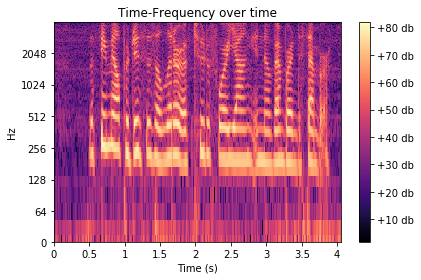

In [110]:
display(ipd.Markdown("""
#### Normalize like zhr1201
"""))

MIN_AMP = 10000
AMP_FAC = 20000

st_spec_2 = np.maximum(st_spec, np.max(st_spec) / MIN_AMP)
st_spec_2 = 20. * np.log10(st_spec_2) + 20 * np.log10(AMP_FAC)
print(np.min(st_spec_2))
print(np.max(st_spec_2))
show_spec(st_spec_2, SAMPLING_RATE, HOP_LENGTH, title="Time-Frequency over time")


#### Normalize [like librosa](https://github.com/librosa/librosa/blob/master/librosa/core/spectrum.py#L815)


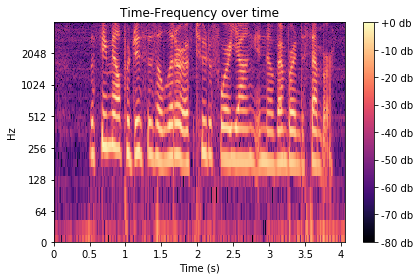

In [93]:
display(ipd.Markdown("""
#### Normalize [like librosa](https://github.com/librosa/librosa/blob/master/librosa/core/spectrum.py#L815)
"""))

ref=np.max(st_spec)**2
amin=1e-5**2
top_db=80.0

st_spec_3 = np.square(st_spec)
st_spec_3 = 10.0 * np.log10(np.maximum(amin, st_spec_3))
st_spec_3 -= 10.0 * np.log10(np.maximum(amin, ref))
#st_spec_3 = 10.0 * np.log10(np.maximum(amin, st_spec_3) / np.maximum(amin, ref))

st_spec_3 = np.maximum(st_spec_3, st_spec_3.max() - top_db)
show_spec(st_spec_3, SAMPLING_RATE, HOP_LENGTH, title="Time-Frequency over time")

In [ ]:
display(ipd.Markdown("""
#### Diff between librosa and zhr1201
"""))

diff = np.abs(st_spec_2 - st_spec_3)
print("Diff sum is %f" % np.sum(diff))
show_spec(diff, SAMPLING_RATE, HOP_LENGTH, title="Diff: Time-Frequency over time")

In [ ]:
display(ipd.Markdown("""
#### Diff between own and zhr1201
"""))
diff = np.abs(st_spec_1 - st_spec_3)
print("Diff sum is %f" % np.sum(diff))
show_spec(diff, SAMPLING_RATE, HOP_LENGTH, title="Diff: Time-Frequency over time")

# Voice Activation Detection

This is probably not needed because it is not mentioned in the original 2015/2016 paper. I'm not sure yet which advantage it could bring

I think to goal is to further normalize the audio and to focus on the important frequencies. Maybe the RNN convergest faster?

In [ ]:
THRESHOLD = 40
GLOBAL_MEAN = 44
GLOBAL_STD = 15.5
MIN_AMP = 10000
AMP_FAC = 10000

SAMPLING_RATE = 8000
audio_files = ["../../workspace/data/2019-05-25/train/MABC0/0.wav",
              "../../workspace/data/TEDLIUM3/train/AaronHuey_2010X/0.wav"]

for audio_file in audio_files:
    test_pcm, _ = librosa.core.load(audio_file, sr=SAMPLING_RATE)

    noisy_spec0 = librosa.core.stft(test_pcm, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, window=np.hanning, center=False)
    
    # Normalize
    noisy_spec = np.abs(noisy_spec0)
    noisy_spec_phase = noisy_spec0 / noisy_spec
    noisy_spec = np.maximum(noisy_spec, np.max(noisy_spec) / MIN_AMP)
    noisy_spec = 20. * np.log10(noisy_spec * AMP_FAC)
    
    # Create VAD filter
    max_mag = np.max(noisy_spec)
    speech_VAD = (noisy_spec > (max_mag - THRESHOLD)).astype(int) # Keep where magnitues are greater than max. magnitude - THRESHOLD. This means keep upper THRESHOLD magnitudes.
    
    audio_name = '...' + audio_file[-10:]
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,5))
    ax1, ax2, ax3 = axes
    
    show_spec(noisy_spec, SAMPLING_RATE, HOP_LENGTH, title="Spectrogram for %s" % audio_name, ax=ax1)
    fig.colorbar(ax1.collections[0], ax=ax1, format='%+2.0f dB')
    # Filter by VAD
    noisy_spec *= speech_VAD
    show_spec(speech_VAD, SAMPLING_RATE, HOP_LENGTH, title="VAD for %s" % audio_name, ax=ax2)
    fig.colorbar(ax2.collections[0], ax=ax2, format='%+2.0f dB')
    # Normalize again
    noisy_spec = (noisy_spec - GLOBAL_MEAN) / GLOBAL_STD
    show_spec(noisy_spec, SAMPLING_RATE, HOP_LENGTH, title="Normalized for %s" % audio_name, ax=ax3)
    fig.colorbar(ax3.collections[0], ax=ax3, format='%+2.0f dB')

    #from matplotlib.cm import ScalarMappable
    #plt.colorbar(ax1.collections[0], format='%+2.0f dB', ax=axes)
    print("noisy_spec: %s" % audio_file) # todo: phase info is missing
    display(ipd.Audio(librosa.istft(np.abs(noisy_spec0) * speech_VAD * noisy_spec_phase), rate=SAMPLING_RATE))
    

## Overlapp-Add

In [69]:
from scipy import signal
import numpy as np

In [76]:
print(signal.check_COLA(signal.hann(120, sym=False), 120, 60))
signal.check_COLA(np.hanning(120 + 1)[:-1], 120, 60)

True


True

In [77]:
print(signal.check_COLA(signal.hann(256, sym=False) ** 2, 256, 192))
signal.check_COLA((np.hanning(256 + 1) ** 2)[:-1], 256, 192)

False


True

In [28]:
display(ipd.Audio(test_pcm, rate=SAMPLING_RATE))
librosa_spec0 = librosa.core.stft(test_pcm, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, window=np.square(np.hanning(256)), center=False)[:,0:400]

librosa_spec = np.abs(librosa_spec0)
phase = librosa_spec0 / librosa_spec

#librosa_spec = 20. * np.log10(np.abs(librosa_spec))
#librosa_spec = 10 ** (librosa_spec / 20)


#librosa_spec = librosa.amplitude_to_db(np.abs(librosa_spec))
#librosa_spec = librosa.db_to_amplitude(librosa_spec)

inv = librosa.istft(librosa_spec*phase, window=np.square(np.hanning(256)), hop_length=64, win_length=256,center=False)
print(inv.shape)
print((300-1)*64 + 256)


display(ipd.Audio(inv, rate=SAMPLING_RATE))

print(np.sum(np.abs(test_pcm[0:25792] - inv)))

(25792,)
19392


0.007763293
